In [1]:
%%time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import wavfile
import os.path
import IPython.display
import seaborn as sns
import librosa
import librosa.display
import soundfile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from keras import optimizers

import warnings

CPU times: user 10.7 s, sys: 2.94 s, total: 13.6 s
Wall time: 28.5 s


In [2]:
pip install librosa

Note: you may need to restart the kernel to use updated packages.


In [2]:
image_dir = Path('Crema')

In [3]:
filepaths = list(image_dir.glob(r'**/*.wav'))

In [4]:
labels = list(map(lambda x: os.path.split(x)[1].split('_')[2], filepaths))

In [5]:
set(labels)

{'ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD'}

In [6]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

audio_df = pd.concat([filepaths, labels], axis=1)
audio_df

,Filepath,Label
0,Crema/1022_ITS_ANG_XX.wav,ANG
1,Crema/1037_ITS_ANG_XX.wav,ANG
2,Crema/1060_ITS_NEU_XX.wav,NEU
3,Crema/1075_ITS_NEU_XX.wav,NEU
4,Crema/1073_IOM_DIS_XX.wav,DIS
...,...,...
7437,Crema/1089_WSI_ANG_XX.wav,ANG
7438,Crema/1025_IWW_ANG_XX.wav,ANG
7439,Crema/1030_IWW_ANG_XX.wav,ANG
7440,Crema/1019_TIE_ANG_XX.wav,ANG


<AxesSubplot:xlabel='Label', ylabel='Count'>

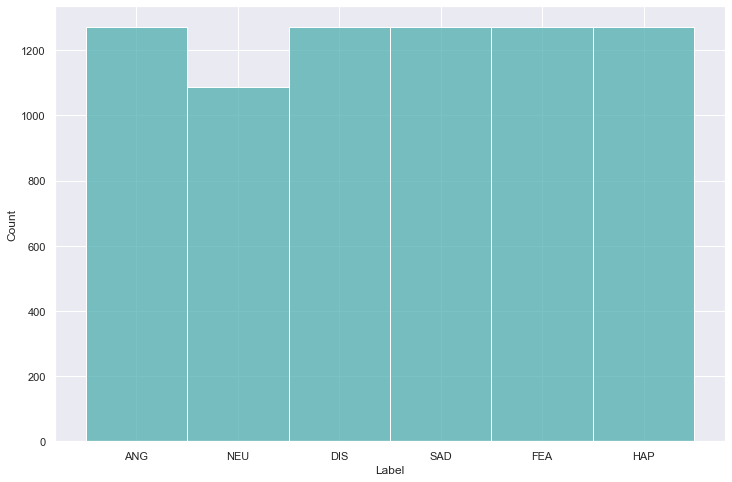

In [7]:
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style('darkgrid')
sns.histplot(labels, color='#4FAEB0')

In [8]:
audio_arrays = []

for i in audio_df['Filepath']:
    x, sr = librosa.load(i, sr=44100)
    audio_arrays.append(x)
    
audio_df['Arrays'] = audio_arrays

In [9]:
audio_df

,Filepath,Label,Arrays
0,Crema/1022_ITS_ANG_XX.wav,ANG,"[0.0002310329, -0.000118470096, -0.0007181751,..."
1,Crema/1037_ITS_ANG_XX.wav,ANG,"[0.00012712345, 0.00013179153, 9.688144e-05, 9..."
2,Crema/1060_ITS_NEU_XX.wav,NEU,"[0.0023588792, 0.0029570358, 0.0031380674, 0.0..."
3,Crema/1075_ITS_NEU_XX.wav,NEU,"[-0.002314643, -0.002472688, -0.002263399, -0...."
4,Crema/1073_IOM_DIS_XX.wav,DIS,"[-0.004999811, -0.005870252, -0.006061584, -0...."
...,...,...,...
7437,Crema/1089_WSI_ANG_XX.wav,ANG,"[-0.0025495547, -0.003178273, -0.0035001733, -..."
7438,Crema/1025_IWW_ANG_XX.wav,ANG,"[-0.0030437936, -0.0038859718, -0.004179765, -..."
7439,Crema/1030_IWW_ANG_XX.wav,ANG,"[0.0037353432, 0.004136463, 0.0038602569, 0.00..."
7440,Crema/1019_TIE_ANG_XX.wav,ANG,"[-0.00021834832, -9.960958e-05, 0.00015413309,..."


In [10]:
import librosa.display
plt.figure(figsize=(12,4))

angfile = audio_df[audio_df['Label'] == 'ANG']['Filepath']
angarray = audio_df[audio_df['Label'] == 'ANG']['Arrays']

#librosa.display.waveplot(angarray.iloc[0], color='#C00808')
IPython.display.Audio(angfile.iloc[0])

<Figure size 864x288 with 0 Axes>

In [11]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [12]:
def extract_features(data):
    # Zero Crossing Rate
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr))

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr, n_fft=200).T, axis=0)
    result = np.hstack((result, chroma_stft))     

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_fft=200).T, axis=0)
    result = np.hstack((result, mfcc))

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr, n_fft=200).T, axis=0)
    result = np.hstack((result, mel))
    
    # Tonnetz
    tonnetz = np.mean(librosa.feature.tonnetz(y=data, sr=sr).T, axis=0);
    result = np.hstack((result, tonnetz));
    
    return result

In [13]:
def get_features(data):
    result = []
    
    # without augmentation
    res1 = extract_features(data)
    result.append(res1)
    
    # with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result.append(res2)
    
    # with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sr)
    res3 = extract_features(data_stretch_pitch)
    result.append(res3)
    
    return result


In [14]:
%%time
warnings.filterwarnings('ignore')

x = []
y = []
for i in range(len(audio_df)):
    feature=get_features(audio_df['Arrays'].iloc[i]);
    for j in feature:
        x.append(j)
        y.append(audio_df['Label'].iloc[i])

CPU times: user 3h 33min 45s, sys: 29min 32s, total: 4h 3min 17s
Wall time: 4h 6min 41s


In [15]:
le = LabelEncoder()
y = utils.to_categorical(le.fit_transform(y))
y

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(np.array(x), np.array(y), test_size=0.1)

In [17]:
print((x_train.shape, y_train.shape, x_test.shape, y_test.shape))

((20093, 167), (20093, 6), (2233, 167), (2233, 6))


In [18]:
x_train = np.expand_dims(x_train,axis=2)
x_test = np.expand_dims(x_test,axis=2)


In [19]:
pip install tensorflow keras

Note: you may need to restart the kernel to use updated packages.


In [20]:
from tensorflow.keras import optimizers
model = Sequential()
model.add(Conv1D(128, 3, activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D((1)))
model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D((1)))
model.add(Conv1D(512, 3, activation='relu'))
model.add(MaxPooling1D((1)))
model.add(Conv1D(1024, 3, activation='relu'))
model.add(MaxPooling1D((1)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.RMSprop(lr=0.0005),
             metrics=['accuracy'])

model.summary()

2022-12-21 03:48:22.504326: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 165, 128)          512       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 165, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 163, 256)          98560     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 163, 256)         0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 161, 512)          393728    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 161, 512)         0

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=128,
                    validation_data=(x_test, y_test))

Epoch 1/100
157/157 [==============================] - 1950s 12s/step - loss: 2.1331 - accuracy: 0.2760 - val_loss: 1.5609 - val_accuracy: 0.3430
Epoch 2/100
 35/157 [=====>........................] - ETA: 43:31 - loss: 1.5970 - accuracy: 0.3232

In [ ]:
y_pred = model.predict(x_test)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r', xticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'], yticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'])

In [ ]:
confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))